In [0]:
!pip install tensorflow-gpu
!pip install keras
!pip install seaborn
!pip3 install impyute

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import statistics as stats
import pandas as pd
import numpy as np
import seaborn as sns
import sys


from __future__ import absolute_import, division, print_function
from impyute.imputation.cs import fast_knn
from tensorflow.keras import layers
from google.colab import files
from tensorflow import keras

## Confirm the GPU has paired successfully with the Notebook ##

device_name = tf.test.gpu_device_name()
if device_name!= "/device:GPU:0":
  raise SystemError("GPU device not found")
print('Found GPU at: {}'.format(device_name))




Found GPU at: /device:GPU:0


Note: I am using  `Tensorflow` at the Backend along with Keras to train the Convolutional Neural Network.





# 1. Downloading the uxscoredata Dataset with GDrive
-  Upload the uxscoredata.xls file on your Google Drive.
-  Upon successfully doing so, you can mount the Google Drive in your Google Colab directory with the help of an authentication code.  
-  Further, get the data into your working directory.


In [0]:
from google.colab import drive ## Mount Google Colab directory so that the dataset could be shared through an authetication code##
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import the dataset using Pandas

In [0]:
data = pd.DataFrame.from_csv('/content/gdrive/My Drive/verge_data.csv')

#data.sort_values("start_time", inplace = True) Sorting would create an inherent bias in the model and can lead to local mimima, since CNN is a stochastic method.

data.head() # Printing the first five rows

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,ux_score_total,network_delay_client_server,network_delay_server_client,network_delay_total,application_delay_client_server,application_delay_server_client,application_delay_total,retransmissions_client,retransmissions_server,zero_windows_server,bytes_client,bytes_server,bytes_total,bits_sec_rx,bits_sec_tx,bits_sec_total,observed_connections
start_time,,,,,,,,,,,,,,,,,
2018-12-01 06:00:00,0.672941,2.042380,1.713958,3.756338,NaN,NaN,NaN,0,84,0,41316,1041298,1082614,138839.73,5508.800,144348.53,2
2018-12-01 06:00:00,2.049524,0.027700,0.742262,0.769962,NaN,469.8571,469.857100,0,206,0,241840,5356137,5597977,714151.60,32245.334,746396.94,3
2018-12-01 06:00:00,2.100000,0.619104,1.05198,1.671084,1.876632,45.273163,47.149796,0,74,0,68376,1000302,1068678,133373.60,9116.800,142490.39,2
2018-12-01 06:00:00,2.812903,0.807649,5.393032,6.200681,27.168175,86.992455,114.160630,0,314,0,465633,8163683,8629316,1088491.10,62084.400,1150575.50,8
2018-12-01 06:00:00,2.907544,1.348179,69.900185,71.248370,75.531260,114.935616,190.466870,0,475,0,349715,6967714,7317429,929028.56,46628.668,975657.25,6


# 2. Data Pre-processing && Clean-up

## 2.1. Remove duplicate rows from the dataset, if any.

In [0]:
print("checking for duplicate values: ")

len1 = len(data)

## removes the duplicates in the dataset , by keeping the first row it finds, and removing other duplicate values##

data.drop_duplicates(subset = None, keep = 'first', inplace = True) 

len2 = len(data)

print("\n"+"Total number of rows in the dataset (including duplicate rows)- " + str(len1) + '\n')

print("Total number of duplicate rows removed- " + str(len1-len2) + '\n')

print("Total number of rows in the datset (after removing duplicate values- " + str(len2) + '\n')

checking for duplicate values: 

Total number of rows in the dataset (including duplicate rows)- 39999

Total number of duplicate rows removed- 5623

Total number of rows in the datset (after removing duplicate values- 34376



## 2.2. Remove the rows with Null values in the ux_score_total columns. 

In [0]:
## Summary of the dataset with total number of null values displayed for each column#

print(data.isna().sum()) 

ux_score_total                      4700
network_delay_client_server         7260
network_delay_server_client         3875
network_delay_total                 3725
application_delay_client_server    13307
application_delay_server_client     7977
application_delay_total             7318
retransmissions_client                 0
retransmissions_server                 0
zero_windows_server                    0
bytes_client                           0
bytes_server                           0
bytes_total                            0
bits_sec_rx                            0
bits_sec_tx                            0
bits_sec_total                         0
observed_connections                   0
dtype: int64


In [0]:
data = data.dropna(subset=['ux_score_total']) ##  Removing rows with null values in the column ux_score_values#

print(data.isna().sum())

print("\n" + "Total number of rows in the dataset after removing null rows-" + str(len(data)))

ux_score_total                        0
network_delay_client_server        2560
network_delay_server_client        1981
network_delay_total                1830
application_delay_client_server    8607
application_delay_server_client    6083
application_delay_total            5423
retransmissions_client                0
retransmissions_server                0
zero_windows_server                   0
bytes_client                          0
bytes_server                          0
bytes_total                           0
bits_sec_rx                           0
bits_sec_tx                           0
bits_sec_total                        0
observed_connections                  0
dtype: int64

Total number of rows in the dataset after removing null rows-29676


## 2.3- Overall Statistics
- The columns ***zero_windows_server*** has a mean and std of 0. Therefore is a dummy feature and would be best to drop it from the data set.
-  Columns **network_delay_total**, **application_delay_total**, **bytes_total**, **bits_sec_total** are an overall representation of the other columns and could br removed as they act as redundant features.

In [0]:
# describe helps to describe the dataset with statistical metrics like mean, std and quartile ranges.
data_stats = data.describe() 

data_stats.pop('ux_score_total')

data_stats = data_stats.transpose()

data_stats

,count,mean,std,min,25%,50%,75%,max
network_delay_client_server,27116.0,2.549675,5.169106e+00,0.000993,1.520943,2.080785,2.748225,1.949084e+02
network_delay_total,27846.0,36.487156,5.567110e+01,0.000662,3.166699,10.943238,42.134483,3.975249e+02
application_delay_client_server,21069.0,12.893559,1.915933e+01,0.000001,2.071073,5.992615,15.447326,1.974451e+02
application_delay_total,24253.0,1215.413466,1.053506e+04,0.000001,6.632373,26.742554,71.671150,2.401875e+05
retransmissions_client,29676.0,0.100890,1.969540e+00,0.000000,0.000000,0.000000,0.000000,3.090000e+02
zero_windows_server,29676.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
bytes_client,29676.0,36019.730119,3.260239e+05,0.000000,586.000000,2053.000000,4501.000000,1.178540e+07
bytes_server,29676.0,103934.988071,9.132648e+05,0.000000,749.000000,1994.000000,5277.250000,2.712497e+07
bytes_total,29676.0,139954.718190,1.017570e+06,0.000000,1488.000000,4420.000000,10262.500000,2.760713e+07
bits_sec_rx,29676.0,13857.998400,1.217686e+05,0.000000,99.866670,265.866670,703.633335,3.616663e+06


In [0]:
# Removing the columns which are redundant in the dataset

data = data.drop(['zero_windows_server','network_delay_total',
                  'application_delay_total','bytes_total','bits_sec_total'],axis=1)

data_stats = data.describe()

data_stats.pop('ux_score_total') # pop removes the ux_score_total column from the dataset

data_stats = data_stats.transpose()

data_stats


,count,mean,std,min,25%,50%,75%,max
network_delay_client_server,27116.0,2.549675,5.169106,0.000993,1.520943,2.080785,2.748225,1.949084e+02
application_delay_client_server,21069.0,12.893559,19.159334,0.000001,2.071073,5.992615,15.447326,1.974451e+02
retransmissions_client,29676.0,0.100890,1.969540,0.000000,0.000000,0.000000,0.000000,3.090000e+02
bytes_client,29676.0,36019.730119,326023.924907,0.000000,586.000000,2053.000000,4501.000000,1.178540e+07
bytes_server,29676.0,103934.988071,913264.771434,0.000000,749.000000,1994.000000,5277.250000,2.712497e+07
bits_sec_rx,29676.0,13857.998400,121768.636192,0.000000,99.866670,265.866670,703.633335,3.616663e+06
bits_sec_tx,29676.0,4802.630683,43469.856651,0.000000,78.133330,273.733340,600.133360,1.571386e+06
observed_connections,29676.0,1.797109,3.916222,1.000000,1.000000,1.000000,2.000000,2.040000e+02


## 2.4 - Dataset Imputation - Infering the NaN values from the existing values in the dataset
- There are two most effective ways of doing it:
(1) **K - Nearest Neighbour Algorithm (K-NN)**
(2) **Multivariate Imputation by Chained Equation (MICE)**

- After some experimentation, it was learnt that **K-NN** works best with our case.


In [0]:
data = data.astype('float64') # Converting the data type to float 64 to avoid overflow

sys.setrecursionlimit(100000) # Increase the recursion limit of the OS

# Start the KNN training
imputed_training=fast_knn(data.values, k=30)

# Imputation with MICE
# Imputed_training=mice(train.values)

columns_name = ['ux_score_total','network_delay_client_server','network_delay_server_client','application_delay_client_server',
                'application_delay_server_client','retransmissions_client','retransmissions_server',
                'bytes_client','bytes_server','bits_sec_rx','bits_sec_tx','observed_connections']

dataset = pd.DataFrame(imputed_training,
                       columns=columns_name) # Stroing the dataset back into the panda frames

dataset.head() # Printing top 5 results of the imputed traingin dataset

,ux_score_total,network_delay_client_server,network_delay_server_client,application_delay_client_server,application_delay_server_client,retransmissions_client,retransmissions_server,bytes_client,bytes_server,bits_sec_rx,bits_sec_tx,observed_connections
0,0.672941,2.042380,1.713958,10.062716,359.196468,0.0,84.0,41316.0,1041298.0,138839.73,5508.800,2.0
1,2.049524,0.027700,0.742262,24.220571,469.857100,0.0,206.0,241840.0,5356137.0,714151.60,32245.334,3.0
2,2.100000,0.619104,1.051980,1.876632,45.273163,0.0,74.0,68376.0,1000302.0,133373.60,9116.800,2.0
3,2.812903,0.807649,5.393032,27.168175,86.992455,0.0,314.0,465633.0,8163683.0,1088491.10,62084.400,8.0
4,2.907544,1.348179,69.900185,75.531260,114.935616,0.0,475.0,349715.0,6967714.0,929028.56,46628.668,6.0


# 3  Feature Engineering && Inspecting the data

## 3.1. Split the data into train and test
- We wil use the train set to train the CNN model
- we will use the test set in the final evaluation of the model

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0) ## Splitting the dataset into train dataset -- 80 % of the data##

test_dataset = dataset.drop(train_dataset.index) ## Splitting the dataset into test dataset--- 20 % of the data##

train_dataset.head()

,ux_score_total,network_delay_client_server,network_delay_server_client,application_delay_client_server,application_delay_server_client,retransmissions_client,retransmissions_server,bytes_client,bytes_server,bits_sec_rx,bits_sec_tx,observed_connections
15758,10.0,1.213046,31.214088,16.266298,88.865234,0.0,1.0,1924.0,2034.0,271.200000,256.533330,1.0
29082,10.0,5.028311,27.790252,12.893559,1237.899733,0.0,0.0,74.0,243.0,32.400000,9.866667,1.0
19011,4.9,1.383548,1.341833,119.446260,357.061860,0.0,0.0,393432.0,71173.0,9489.733000,52457.600000,1.0
23402,10.0,2.748225,0.713460,9.345404,14.810900,0.0,0.0,6673.0,19625.0,2616.666700,889.733340,1.0
19519,10.0,1.558354,56.216280,12.893559,1237.899733,0.0,0.0,221.0,128.0,17.066668,29.466667,1.0


## 3.2. Correlogram or Correlation matrix with Seaborn (pairplots)
- Very high-correlation **(r-square =1)** noted between the features  **(bits_sec_tx, bytes_client) && (bits_sec_rx,bytes_server)** 
- Thus eliminating one of the festures within the pairs would be appropriate to reduce the **Curse of Dimensionality**

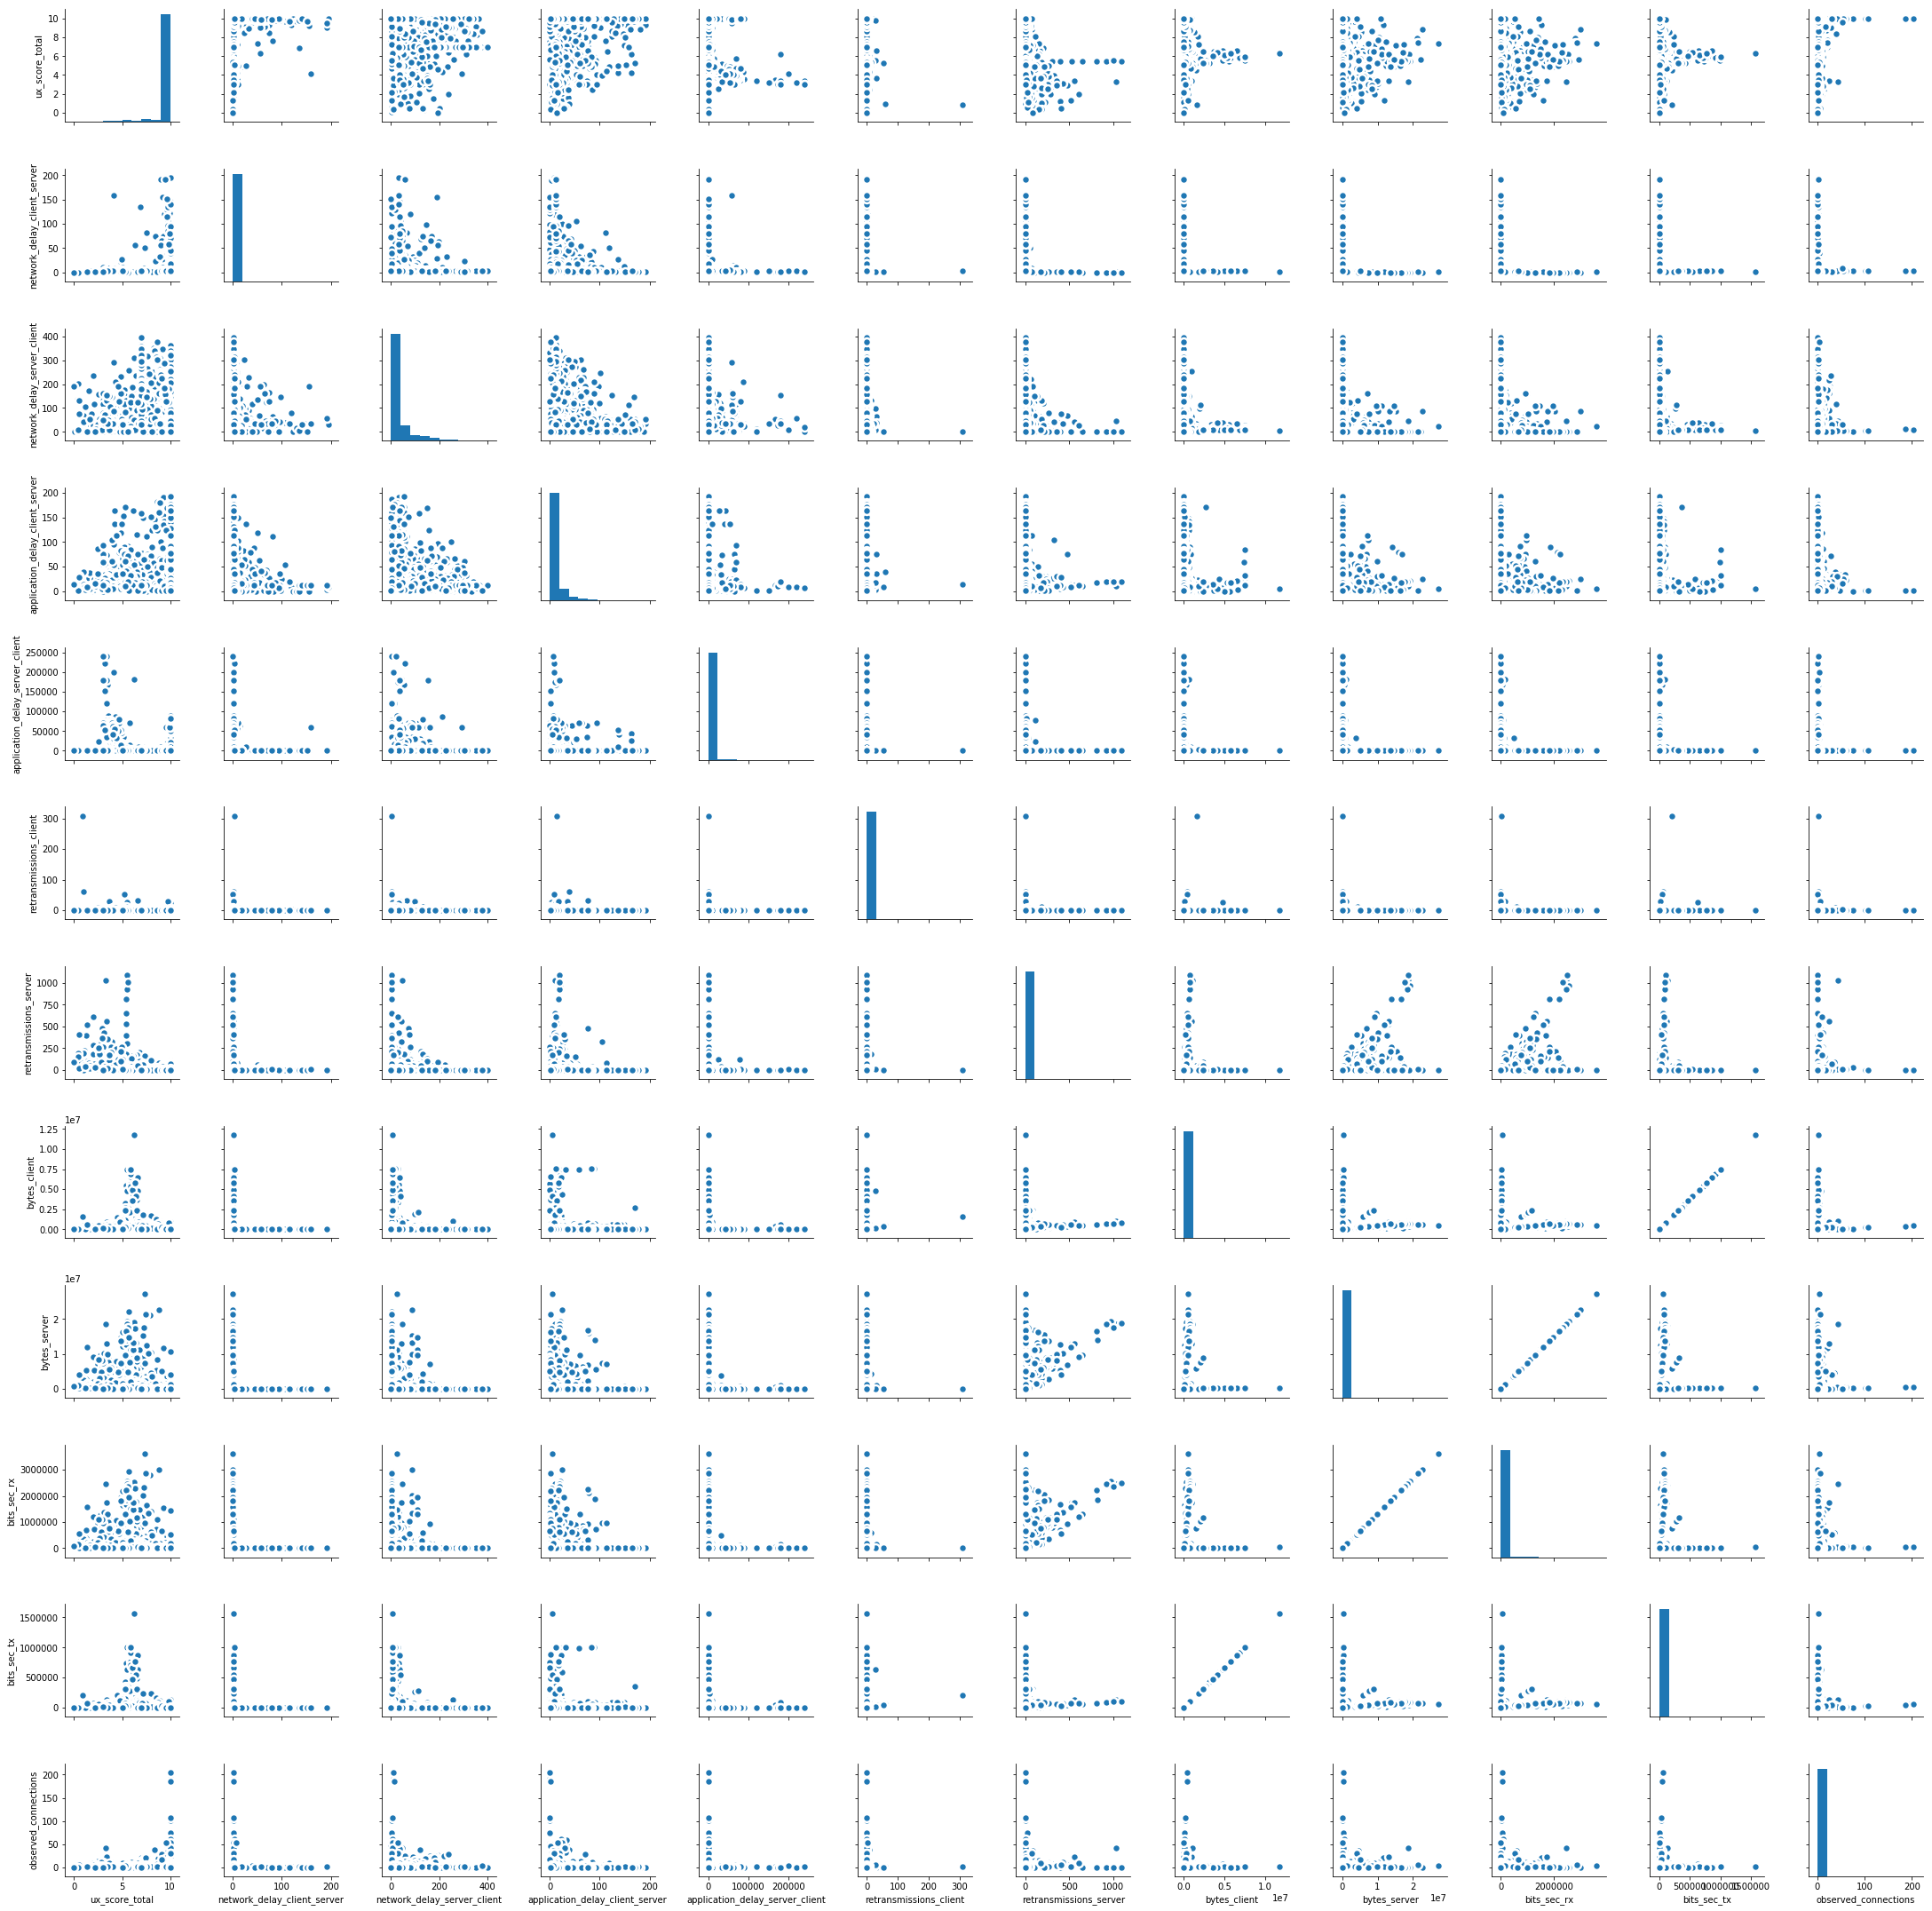

In [0]:
## plotting the pairplots bw all the features and true label using Seaborn library ##
sns.pairplot(train_dataset, kind="scatter", 
             plot_kws=dict(s=80, edgecolor="white", linewidth=2.5)) 
plt.show()


## Removing feature bits_sec_tx && bits_rec_rx from training dataset to reduce feature complexity ##
train_dataset = train_dataset.drop(['bits_sec_tx'
                                    ,'bits_sec_rx'],axis=1) 


## Removing feature bits_sec_tx && bits_rec_rx from testing dataset to reduce feature complexity ##
test_dataset = test_dataset.drop(['bits_sec_tx'
                                  ,'bits_sec_rx'],axis=1) 

## 3.3. Split features from labels
- Separate the target value or labels from the features. This label is thevalue we would use to train the model.

In [0]:
train_labels = train_dataset.pop("ux_score_total")

test_labels = test_dataset.pop("ux_score_total")

## 3.4. Data bias && Sensitivity/Specifity check
- Check the distribution of train_labels with Bivariate Kernel Density Estimate
- The training  and test dataet is inherently skewed towards the **label 10 [ux_score_label]**, thus increasing the **specificity** in the model at the cost of **sensitivity**.


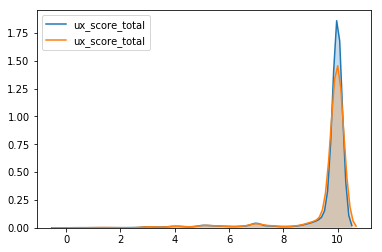

In [0]:
sns.kdeplot(train_labels, shade=True)

sns.kdeplot(test_labels, shade=True)

In [0]:
## Overall statistics of the dataset after Feature Engineering and Data Clean up ##

train_stats = train_dataset.describe() 

train_stats = train_stats.transpose()

train_stats

,count,mean,std,min,25%,50%,75%,max
network_delay_client_server,23741.0,2.575698,5.300186,0.000993,1.568948,2.149648,2.713132,1.949084e+02
network_delay_server_client,23741.0,33.718226,53.381533,0.000662,1.081611,11.380585,37.784534,3.975249e+02
application_delay_client_server,23741.0,12.760149,16.031669,0.000001,3.275787,10.429540,13.005213,1.921569e+02
application_delay_server_client,23741.0,1228.726014,9492.739299,0.000001,2.857919,29.276062,261.480560,2.401875e+05
retransmissions_client,23741.0,0.103871,2.182123,0.000000,0.000000,0.000000,0.000000,3.090000e+02
retransmissions_server,23741.0,2.330778,24.489245,0.000000,0.000000,0.000000,0.000000,1.090000e+03
bytes_client,23741.0,36455.141232,327914.072975,0.000000,587.000000,2044.000000,4474.000000,1.178540e+07
bytes_server,23741.0,105214.784676,936336.251437,0.000000,748.000000,1990.000000,5281.000000,2.712497e+07
observed_connections,23741.0,1.769260,3.374779,1.000000,1.000000,1.000000,2.000000,2.040000e+02


## 3.4. Normalizing the data
- In the train_stats above, we can see the differennt range values for each feature. Therefore, it would be a good practise to nromalize the features in the same scales and ranges, therefore making the resulatant model free of the coices of the units of the imputs.
- Nromalization method used- **Z-score**

In [0]:
def norm(x):
  return(x - train_stats['mean'])/ train_stats['std'] ## Z - score
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#       4. The Model

## 4.1. Architecture of the CNN model
- Here we will use **Sequential model** with **two densely** connected hidden layers (of 20 units each) and an output layer that returns a single, continuous value. 
- The model building steps are wrpapped in a fucntion, **build_function**.

In [0]:
print("Effective number of training examples- "+ str(train_dataset.shape[0]))

print("Effective number of features- "+ str(train_dataset.shape[1]))

Effective number of training examples- 23741
Effective number of features- 9


In [0]:
def build_model(): ## build_model is class for definign the architecture of the dataset ##
  
## Using Rectified Linear Unit as an activation function in the Hidden Unit -1 && 2 ##
  model = keras.Sequential([
      layers.Dense(20, activation=tf.nn.relu, 
                   input_shape = [train_dataset.shape[1]]), 
      
      layers.Dense(20, 
                   activation=tf.nn.relu),                                                      
      
      layers.Dense(1)   ## Output unit is a linear unit ##                                       
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)  ## Using Root Mean Square as an Optimizer function ##
  
  model.compile(loss='mse',optimizer = optimizer, 
                metrics=['mae','mse']) ## Mean abs Error && Mean Square Error as metric to monitor performance ##
  
  return model
     

In [0]:
model = build_model() ## compiling the model

## 4.2.  Inspect the model
- Using the simple .summary method to print the description of the model

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                200       
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [0]:
## This class helps us visualize the training of model in progress with dots........#

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs):
    if epoch%100 == 0: print('')
    print('.',end='')
    
EPOCHS = 1000   # Total number of EPOCHS being used

## Fitting the model with 20 % validation Data set and stores the metrics such as ##
## Training error && Validation Error to Keras after each callback/epoch  ##

history = model.fit(
    normed_train_data, train_labels,
    epochs = EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.463642,0.288189,0.463641,0.627007,0.305552,0.627007,995
996,0.456770,0.287423,0.456770,0.657930,0.332293,0.657930,996
997,0.455232,0.287972,0.455232,0.644933,0.304793,0.644933,997
998,0.453350,0.287104,0.453350,0.628939,0.284240,0.628939,998
999,0.456605,0.289368,0.456605,0.653205,0.316114,0.653205,999


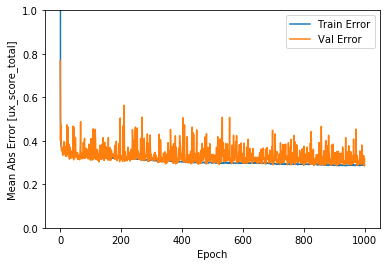

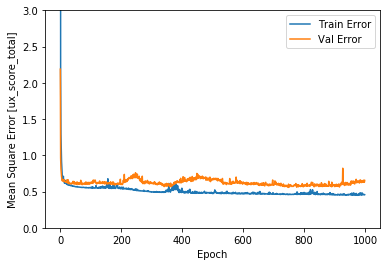

In [0]:
## Plotting the history of the training the model with metrics such as Trainiong Error && Validation Error ## 

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ux_score_total]')
  
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label = 'Train Error')
  
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  
  plt.legend()
  plt.ylim([0,1])
  plt.figure()
  plt.xlabel('Epoch')
  
  plt.ylabel('Mean Square Error [ux_score_total]')
  
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label = 'Train Error')
  
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  
  plt.legend()
  plt.ylim([0,3])

plot_history(history)

Please note: **After 100 epochs, the Validation error increases upon further training, thus causing the problem of Overfitting**.

## 4.3. Avoiding Overfitting- Early Stop Technique
-  In order to avoid **Overfitting problem**, we will be calling the method early stop before fitting the model this time 
- Once the **Value Loss** metric starts to increase for **10 consicutive values**, we would stop training the model further 


.....................................................................

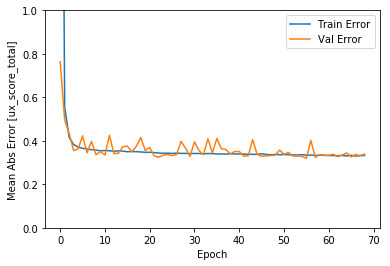

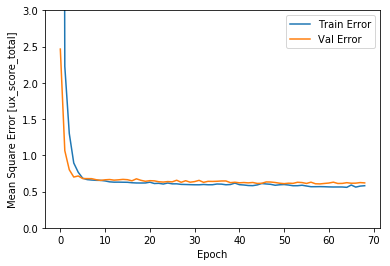

In [0]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=10)

history = model.fit(normed_train_data, train_labels, epochs= EPOCHS,
                   validation_split = 0.2, verbose = 0, callbacks=[early_stop,PrintDot()])

plot_history(history)

# 5.  Evaluation
- We are using three ways to qauntify our predictions accuracy :- 

## 5.1. Calculating the mean absolute error in the Testing data set

Please note here that the avergae value is very less compared to the mean and the std of the train label

In [0]:
train_labels.describe() ## Stats on the train_labels to compare the mean abdolute error

count    23741.000000
mean         9.560963
std          1.309118
min          0.000000
25%         10.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: ux_score_total, dtype: float64

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, 
                                test_labels, verbose=0)


print("Tesiting set mean abs error: {:5.2f} ux_score_total".format(mae)) ##The  mean abs error is less that 0.5 with mean and std as 9.5 && 1.31.

Tesiting set mean abs error:  0.34 ux_score_total


## 5.2. Comparing the True Labels with Predictions on a linear plot
- A good model will fit close to the linear line that passes through the origin and has a slope of 45 degrees
- This would mean that we got most of the predictions correct

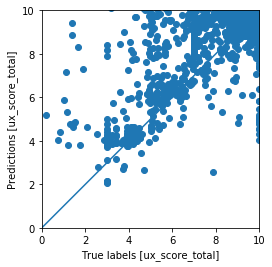

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)

plt.xlabel('True labels [ux_score_total]')

plt.ylabel('Predictions [ux_score_total]')

plt.axis('equal')

plt.axis('square')

plt.xlim([0,10])

plt.ylim([0,10])

_=plt.plot([-10,10],[-10,10])


## 5.3. Histogram on Prediction Error
- The prediction error is centred around **mean 0**, whish means we got most of the labels predicted correctly.
- At the same time, we would expect a more distributed curve acroos the X axis, which is not the case here. Here the plot is centred around 0, this is due to the inherent **skewness in the dataset towards label 10**. And therefore the model is trained to be ***specific, rather then sensitivity***.

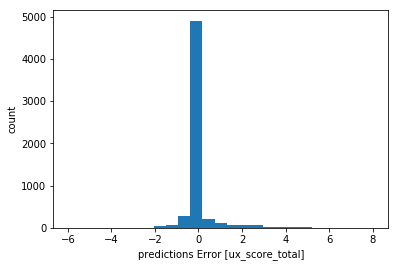

In [0]:
error = test_predictions - test_labels

plt.hist(error, bins = 25)

plt.xlabel("predictions Error [ux_score_total]")

_= plt.ylabel("count")